In [1]:
#Please select GPU first (from Edit->NotebookSetting)
import pandas as pd
import numpy as np
import io
import os
import re
from google.colab import drive
!pip install fastai==2.3.1
from fastai.text.all import *
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/colab_data'
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']


In [25]:
# covid_tweet = pd.read_csv(os.path.join(path, "vaccination_all_tweets.csv"))
covid_tweet = pd.read_csv(os.path.join(path, "covidvacc_tweet_sentiment.csv"))

covid_tweet = covid_tweet[covid_tweet.text.isnull()==False].drop_duplicates().reset_index(drop=True)
covid_tweet = tweet_proc(covid_tweet,'text')
# covid_tweet['emotion'] = np.nan
covid_tweet['sentiment'] = np.nan
covid_tweet.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,orig_text,emotion,sentiment
0,0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm,['PfizerBioNTech'],Twitter for Android,0,0.0,False,Same folks said daikon paste could treat a cytokine storm,worry,NaN
1,1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",NaN,Twitter Web App,1,1.0,False,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",worry,NaN
2,2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,Russian vaccine is created to last 2-4 years,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0.0,False,Russian vaccine is created to last 2-4 years,neutral,NaN


In [26]:
basic_tweet = pd.read_csv(os.path.join(path, "tweet_dataset.csv"))
basic_tweet = basic_tweet[basic_tweet.sentiment!='empty'].drop_duplicates().reset_index(drop=True)
basic_tweet = basic_tweet[['sentiment','new_sentiment','old_text']].rename(columns={'old_text':'text', 'sentiment':'emotion', 'new_sentiment':'sentiment'})
basic_tweet = tweet_proc(basic_tweet,'text')
basic_tweet.head(3)

,emotion,sentiment,text,orig_text
0,sadness,negative,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...
1,sadness,negative,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...
2,enthusiasm,positive,wants to hang out with friends SOON!,wants to hang out with friends SOON!


In [27]:
df_lm = basic_tweet[['text', 'emotion','sentiment']].append(covid_tweet[['text', 'emotion','sentiment']]) 
df_clas = df_lm[['text', 'emotion','sentiment']].dropna(subset=['emotion']).dropna(subset=['sentiment'])
print(len(df_lm), len(df_clas))
df_clas.head(3)

128084 30678


,text,emotion,sentiment
0,Layin n bed with a headache ughhhh...waitin on your call...,sadness,negative
1,Funeral ceremony...gloomy friday...,sadness,negative
2,wants to hang out with friends SOON!,enthusiasm,positive


In [29]:
dls_lm = TextDataLoaders.from_df(df_lm, text_col='text', is_lm=True, valid_pct=0.1)
torch.save(dls_lm, os.path.join(path, 'dls_lm.pkl'))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [30]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos retweet @ erc_research : xxmaj more from xxmaj uur ahin - revisit this piece on the vaccine & & more : \n\n xxmaj from can xxbos xxmaj another vector vaccine , xxmaj johnson & & xxmaj johnsons ( xxunk ) xxmaj adenovirus 26 ( xxunk ) , is on the verge of getting the health mi xxbos xxmaj first dose xxbos i participated in the vaccine study . xxmaj your body","retweet @ erc_research : xxmaj more from xxmaj uur ahin - revisit this piece on the vaccine & & more : \n\n xxmaj from can xxbos xxmaj another vector vaccine , xxmaj johnson & & xxmaj johnsons ( xxunk ) xxmaj adenovirus 26 ( xxunk ) , is on the verge of getting the health mi xxbos xxmaj first dose xxbos i participated in the vaccine study . xxmaj your body will"
1,"xxmaj cooperation , ex : sending a military xxunk in 20 xxbos xxmaj better xxmaj comrade xxbos xxmaj ahh dang of course it had to do that xxmaj she better e - mail you back fast ! xxbos xxmaj just had my 2nd xxmaj moderna vaccine and although i only had a mild response to the 1st , this ones an a xxbos xxmaj making egg xxunk & & xxmaj chinese egg","cooperation , ex : sending a military xxunk in 20 xxbos xxmaj better xxmaj comrade xxbos xxmaj ahh dang of course it had to do that xxmaj she better e - mail you back fast ! xxbos xxmaj just had my 2nd xxmaj moderna vaccine and although i only had a mild response to the 1st , this ones an a xxbos xxmaj making egg xxunk & & xxmaj chinese egg pudding"


In [31]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult = 0.3, metrics=[accuracy, Perplexity()]).to_fp16()

In [15]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3) #4 means 4 epoch
learn.save_encoder(os.path.join(path, 'finetuned_lm')) # save encoder

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.225814,4.093860,0.296126,59.970913,08:59
1,3.901525,3.867120,0.319567,47.804501,09:00
2,3.704673,3.791536,0.329304,44.324444,09:00
3,3.569245,3.789139,0.331305,44.218315,08:56


In [16]:
TEXT = "I love"
N_WORDS = 45
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i love that song i have a sore arm If i met you overnight , you would be looking forward to the next Jab . So relieved I 'm excited for my Moderna vaccine ! And you know
i love my early night dream So , i am now fully vaccinated . Indian Immunologicals Limited ( iil ) to start production of drug substance for under Mission COVISHIELD Covaxin What about the Russian


In [6]:
dls_lm= torch.load(os.path.join(path, 'dls_lm.pkl'))

In [11]:
dls_clas = DataBlock(
    blocks = (TextBlock.from_df('text', seq_len = dls_lm.seq_len, vocab = dls_lm.vocab), CategoryBlock),
    # blocks = (TextBlock.from_df('text', seq_len = 72, vocab = vocab_list), CategoryBlock),
    get_x = ColReader('text'),
    get_y = ColReader('emotion'),
    splitter = RandomSplitter()
).dataloaders(df_clas, bs = 64)
torch.save(dls_clas, os.path.join(path, 'dls_clas_emo.pkl'))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [28]:
dls_clas = torch.load(os.path.join(path, 'dls_clas_emo.pkl'))

In [29]:
dls_clas.show_batch(max_n=4)

,text,category
0,xxbos xxup pirate xxup voice : xxrep 3 a xxrep 3 r xxrep 3 g xxrep 3 h xxrep 3 ! i 4got xxup my xxup damn xxup wallet xxup at xxup work xxup xxunk xxrep 3 ! xxup dammit xxrep 3 ! xxup so xxup close xxup yet xxup so xxup far xxrep 3 ! xxup now xxup i m xxup starving xxrep 3 !,worry
1,"xxbos xxup mad xxup as xxup hell ! xxup someone xxup stole xxup my xxup pink & & xxup black xxup xxunk xxup print xxup pumps i xxup wanted xxup to xxup wear xxup today xxup but xxup to xxup god xxup be xxup the xxup glory , xxup he 'll xxup bless xxup me xxup xxunk",hate
2,"xxbos * * jaw xxmaj drops * * * * gasp * * xxmaj whatever do u mean ? xxmaj i 'm as sweet as pie xxmaj allow me to re - introduce myself , xxmaj i 'm xxmaj coach & & xxmaj i 'm a xxmaj cancer & & u ?",fun
3,xxbos g xxrep 4 r xxrep 3 ! xxmaj it 's xxup back xxrep 5 ! xxmaj and what i mean is my headache xxmaj but on the * * bright side … .it 's only on one side xxrep 4 ! / \ / \ / \ / \ / \,worry


In [13]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [14]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))
learn.save(os.path.join(path, 'twitter_classifier_emo'))

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,2.092638,1.962346,0.345069,21:42
1,1.925229,1.869655,0.356153,22:16


Path('/content/drive/MyDrive/colab_data/twitter_classifier_emo.pth')

In [21]:
learn.predict("I am so worried")

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


('worry',
 tensor(11),
 tensor([0.0187, 0.0337, 0.0326, 0.0335, 0.0357, 0.0722, 0.0358, 0.0659, 0.0415,
         0.2090, 0.0511, 0.3703]))

In [22]:
learn.dls.vocab[1]

['anger', 'boredom', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']

Predict

In [23]:
pred_dl = dls_clas.test_dl(covid_tweet['text'])
preds = learn.get_preds(dl=pred_dl)
# Get predicted sentiment
covid_tweet['emotion'] = preds[0].argmax(dim=-1)


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


KeyError: ignored

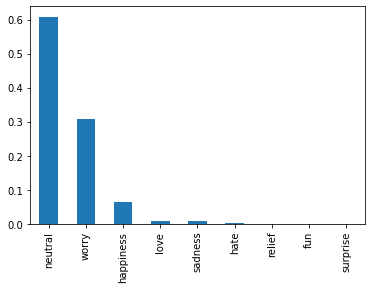

In [24]:
covid_tweet['emotion'] = covid_tweet['emotion'].map({0:'anger', 1:'boredom', 2:'enthusiasm', 3:'fun', 4:'happiness', 5:'hate', 6:'love', 7:'neutral', 8:'relief', 9:'sadness', 10:'surprise', 11:'worry'})

# Save to csv
covid_tweet.to_csv(os.path.join(path, 'covidvacc_tweet_sentiment.csv'))

# Plot sentiment value counts
covid_tweet['emotion'].value_counts(normalize=True).plot.bar();

In [32]:
dls_clas = torch.load(os.path.join(path, 'dls_clas_sentiment_cpu.pkl'))
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).load(os.path.join(path, 'twitter_classifier_sentiment'))
learn.dls.vocab[1]

['negative', 'neutral', 'positive']

In [33]:
covid_tweet.head(3)

,Unnamed: 0,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,orig_text,emotion,sentiment
0,0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm,['PfizerBioNTech'],Twitter for Android,0,0.0,False,Same folks said daikon paste could treat a cytokine storm,worry,NaN
1,1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",NaN,Twitter Web App,1,1.0,False,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev",worry,NaN
2,2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,Russian vaccine is created to last 2-4 years,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0.0,False,Russian vaccine is created to last 2-4 years,neutral,NaN


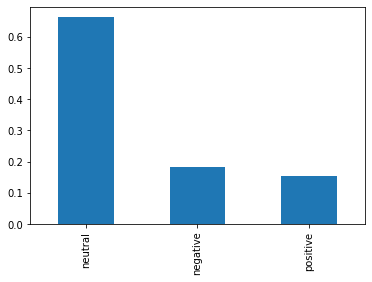

In [34]:

pred_dl = dls_clas.test_dl(covid_tweet['text'])
preds = learn.get_preds(dl=pred_dl)
# Get predicted sentiment
covid_tweet['sentiment'] = preds[0].argmax(dim=-1)
covid_tweet['sentiment'] = covid_tweet['sentiment'].map({0:'negative', 1:'neutral', 2:'positive'})

# Save to csv
covid_tweet.to_csv(os.path.join(path, 'covidvacc_tweet_sentiment2.csv'))

# Plot sentiment value counts
covid_tweet['sentiment'].value_counts(normalize=True).plot.bar();